# Mapping Model Inference

## Install Dependencies

Uncomment if using Colab

In [ ]:
# import os

# os.chdir("/content")

# repo_dir = "rg_sound_generation"
# if not os.path.exists(repo_dir):
#   !git clone https://github.com/TheSoundOfAIOSR/$repo_dir

# os.chdir(repo_dir)
# os.chdir('mapping_models')
# !python -m pip -q install -e .
# os.chdir('examples')

## Imports

Restart kernel after installing `mapping_models` above

In [1]:
%matplotlib inline

import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import ddsp.training
import gin

from mapping_models.trainer import create_dataset
from IPython.display import Audio

# os.chdir("/content/rg_sound_generation/mapping_models/examples")

import z_generator
import causal_conv_test

## Mount Google Drive

Uncomment if using Colab

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Load Data and Model Checkpoints

If you don't have the checkpoints, please take a look at the following:

Training a mapping model: [Notebook](https://github.com/TheSoundOfAIOSR/rg_sound_generation/blob/main/mapping_models/examples/run_training.ipynb)

Training DDSP on Nsynth Guitar Subset: [Notebook](https://github.com/TheSoundOfAIOSR/rg_sound_generation/blob/main/members/fabio/train_ddsp_nsynth_guitar.ipynb)

In [2]:
dataset_dir = 'd:/soundofai/complete_data'
set_name = 'test'
batch_size = 1
z_model_checkpoint = 'checkpoints/z_gen_2/cp.ckpt'
mapping_model_checkpoint = 'd:/soundofai/causal_single_stage/cp.ckpt'
gin_file_path = 'd:/soundofai/ddsp_trained_30k/operative_config-30000.gin'
ddsp_model_path = 'd:/soundofai/ddsp_trained_30k'
sr = 16000

In [3]:
def map_func(features):
    inputs, outputs = z_generator.features_map(features)
    return inputs, outputs, features


dataset = create_dataset(
    dataset_dir=dataset_dir,
    split=set_name,
    batch_size=batch_size,
    map_func=map_func
)

datagen = iter(dataset)

In [4]:
def plot(z):
    for i in range(0, 16):
        plt.plot(range(0, 1000), z[:, i])

In [5]:
mapping_model = causal_conv_test.create_model(model_type='single_stage')
z_model = z_generator.create_model()

_ = mapping_model.load_weights(mapping_model_checkpoint)
_ = z_model.load_weights(z_model_checkpoint)

gin.parse_config_file(gin_file_path)
ddsp_model = ddsp.training.models.Autoencoder(encoder=None)
ddsp_model.restore(ddsp_model_path)

## Get Predictions

In [6]:
def get_preds():
    inputs, outputs, features = next(datagen)

    z_gt = np.squeeze(outputs.get('z_output').numpy())
    f0_scaled = np.squeeze(features.get('f0_scaled').numpy())
    ld_scaled = np.squeeze(features.get('ld_scaled').numpy())

    z_pred = z_model.predict(inputs)
    
    # Update the z in features and in inputs for mapping model
    features['z'] = tf.convert_to_tensor(z_pred)
    inputs['latent_sample'] = features['z']
    
    # Get f0 and ld from predicted z
    f0_pred, ld_pred = mapping_model.predict(inputs)
    # Update the features with predicted f0 and ld
    features['f0_scaled'] = tf.convert_to_tensor(f0_pred)
    features['ld_scaled'] = tf.convert_to_tensor(ld_pred)

    f0_pred = np.squeeze(f0_pred)
    ld_pred = np.squeeze(ld_pred)
    
    z_pred = np.squeeze(z_pred)

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    plt.plot(f0_scaled, label='f0_gt')
    plt.plot(f0_pred, label='f0_pred')
    plt.xlabel('time')
    plt.ylabel('f0_scaled')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(ld_scaled, label='ld_gt')
    plt.plot(ld_pred, label='ld_pred')
    plt.xlabel('time')
    plt.ylabel('ld_scaled')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.xlabel('time')
    plt.ylabel('actual z')
    plot(z_gt)
    plt.ylim([-7., 7.])

    plt.subplot(2, 2, 4)
    plt.xlabel('time')
    plt.ylabel('predicted z')
    plot(z_pred)
    plt.ylim([-7., 7.])

    plt.show()

    ddsp_outputs = ddsp_model(features, training=False)
    audio_pred = ddsp_model.get_audio_from_outputs(ddsp_outputs)
    
    return features['audio'], audio_pred

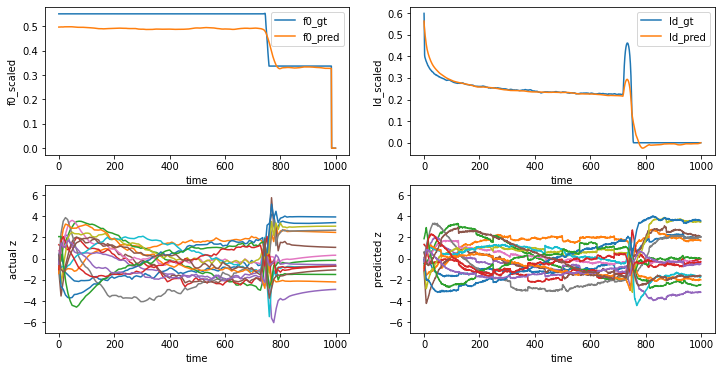

In [10]:
audio, audio_pred = get_preds()

In [11]:
print('Original Audio')
Audio(audio, rate=sr)

Original Audio


In [12]:
print('Predicted Audio')
Audio(audio_pred, rate=sr)

Predicted Audio
